In [ ]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("Employment_text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([77, 768])

In [2]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,Employment Law in Egypt 2021,28,5,7.00,"[-0.0278521236, -0.00480376603, -0.049783919, ..."
1,-39,Table of Contents.0 1 . Introduction p a g e 4...,271,90,67.75,"[-0.00471890857, -0.0247335602, -0.0204362068,..."
2,-39,Collective Labour Relationships,31,3,7.75,"[0.00592021365, -0.046758119, -0.00790522061, ..."
3,-38,1 0 . Vocational Training p a g e 2 6 1 2 . Ch...,363,103,90.75,"[-0.0123509914, 0.00391751109, -0.0049035633, ..."
4,-37,4 With a population of over 100 million and a ...,2161,347,540.25,"[0.00763479294, 6.7258421e-05, -0.010323761, -..."


Models
--
all-mpnet-base-v2

all-distilroberta-v1

(image, text)
--
 timm/ViT-B-16-SigLIP 
 Marqo/marqo-fashionSigLIP

In [3]:
from sentence_transformers import util, SentenceTransformer
from transformers import AutoModel, AutoProcessor

embedding_model = SentenceTransformer(model_name_or_path="all-distilroberta-v1", 
                                      device=device) # choose the device to load the model to

#model = AutoModel.from_pretrained('Marqo/marqo-fashionSigLIP', trust_remote_code=True)
#processor = AutoProcessor.from_pretrained('Marqo/marqo-fashionSigLIP', trust_remote_code=True)

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [10]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "defending salaries"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: defending salaries
Time take to get scores on 77 embeddings: 0.00010 seconds.


torch.return_types.topk(
values=tensor([0.3981, 0.3783, 0.3413, 0.3249, 0.3074], device='cuda:0'),
indices=tensor([ 1, 66,  8, 65, 15], device='cuda:0'))

In [11]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [12]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'defending salaries'

Results:
Score: 0.3981
Text:
Table of Contents.0 1 . Introduction p a g e 4 0 3 . Wages p a g e 1 0 0 4 .
Vacations p a g e 1 1 0 5 . Penalties p a g e 1 4 0 6 . Termination p a g e 1 6
0 2 . Contracts p a g e 7 p a g e 1 9 0 7 . Downsizing p a g e 2 1 0 8 .
Employee Representation p a g e 2 3 0 9 .
Page number: -39


Score: 0.3783
Text:
The calculation of insurance will therefore be based on the comprehensive wage
and not the base and variable salary as was previously the case. This will in
turn increase workers’ pensions within Egypt. 1 5
Page number: -4


Score: 0.3413
Text:
6 Legal Deﬁnitions Worker: any natural person working in return for a wage with
and under the management or supervision of the employer excluding: - Public
servant of any state entity, including the local government units and the public
departments. -Domestic servants and the like. -Employee’s family members that
they support. Employer: any natural or judicial person employing one or

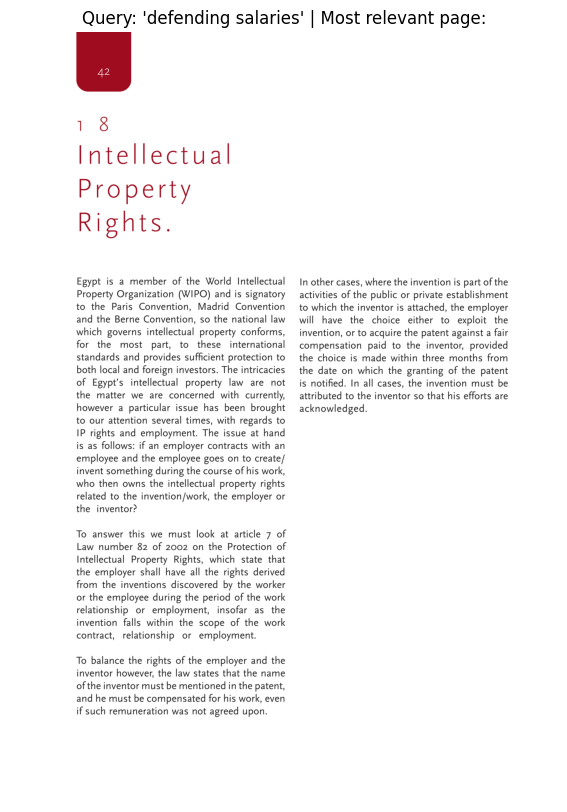

In [ ]:
import fitz

def open_page(pdf_path:str, page_num:int, page_shift:int = 41):
    
    doc = fitz.open(pdf_path)
    try:
        page = doc.load_page(page_num + page_shift) # number of page (our doc starts page numbers on page 41)
        
        # Get the image of the page
        img = page.get_pixmap(dpi=300)
        
        # Optional: save the image
        #img.save("output_filename.png")
        doc.close()
        
        # Convert the Pixmap to a numpy array
        img_array = np.frombuffer(img.samples_mv, 
                                  dtype=np.uint8).reshape((img.h, img.w, img.n))
        
        # Display the image using Matplotlib
        import matplotlib.pyplot as plt
        plt.figure(figsize=(13, 10))
        plt.imshow(img_array)
        plt.title(f"Query: '{query}' | Most relevant page:")
        plt.axis('off') # Turn off axis
        plt.show()
    except:
        print("page does not exist")

open_page("Employment-Law",page_num = 1)

In [15]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer = embedding_model,
                                threshold: float = 0.5,
                                print_time: bool = True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)}) embeddings: {end_time - start_time:.5f} seconds.")

    # Get indices where the dot score is above the threshold
    indices = torch.where(dot_scores > threshold)[0]
    
    # Retrieve the corresponding scores
    scores = dot_scores[indices]

    return scores, indices
def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 threshold: float = 0.5):
    """
    Finds relevant passages given a query and prints them out along with their scores.
    """
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  threshold=threshold)

    # Loop through zipped together scores and indices from torch.topk
    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [20]:
query = "defending salaries"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings,
                                             threshold=0.3)
scores, indices

[INFO] Time taken to get scores on (77) embeddings: 0.00004 seconds.


(tensor([0.3981, 0.3413, 0.3074, 0.3249, 0.3783], device='cuda:0'),
 tensor([ 1,  8, 15, 65, 66], device='cuda:0'))

In [21]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings,
                            threshold=0.3)

[INFO] Time taken to get scores on (77) embeddings: 0.00007 seconds.
Score: 0.3981
Text:
Table of Contents.0 1 . Introduction p a g e 4 0 3 . Wages p a g e 1 0 0 4 .
Vacations p a g e 1 1 0 5 . Penalties p a g e 1 4 0 6 . Termination p a g e 1 6
0 2 . Contracts p a g e 7 p a g e 1 9 0 7 . Downsizing p a g e 2 1 0 8 .
Employee Representation p a g e 2 3 0 9 .
Page number: -39


Score: 0.3413
Text:
6 Legal Deﬁnitions Worker: any natural person working in return for a wage with
and under the management or supervision of the employer excluding: - Public
servant of any state entity, including the local government units and the public
departments. -Domestic servants and the like. -Employee’s family members that
they support. Employer: any natural or judicial person employing one or more
workers in return for a wage. Wages: everything that the worker obtains in
return for his work, whether ﬁxed or variable, in cash or in kind. This includes
commission, performance based percentages, increment

In [22]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 16 GB


meta-llama/Llama-3.2-1B
google/gemma-1.1-2b-it
meta-llama/Llama-3.2-3B-Instruct
microsoft/git-large-vqav2

In [23]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# 1. Remove quantization config
use_quantization_config = False

# 2. Set the model ID
model_id = "microsoft/Phi-3.5-mini-instruct"

# 3. Instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=False,  # use as much memory as we can
)

# Move the model to GPU
llm_model.to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3SdpaAttention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMSNorm((3072,)

In [13]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

In [25]:
llm_model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3SdpaAttention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMSNorm((3072,)

In [26]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

3821079552

In [30]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "Can you provide ways to eat combinations of bananas and dragonfruits?"},
    {"role": "assistant", "content": "Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey."},
    {"role": "user", "content": "What about solving an 2x + 3 = 7 equation?"},
]

pipe = pipeline(
    "text-generation",
    model=llm_model,
    tokenizer=tokenizer,
    device="cuda"
)

generation_args = {
    "max_new_tokens": 500,
    "return_full_text": False,
    "temperature": 0.8,
    "do_sample": False,
}

output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


 To solve the equation 2x + 3 = 7, follow these steps:

Step 1: Isolate the term with the variable (2x) by subtracting 3 from both sides of the equation.
2x + 3 - 3 = 7 - 3
2x = 4

Step 2: Solve for x by dividing both sides of the equation by the coefficient of x, which is 2.
2x / 2 = 4 / 2
x = 2

So, the solution to the equation 2x + 3 = 7 is x = 2.


In [18]:
messages

[{'role': 'system', 'content': 'You are a helpful AI assistant.'},
 {'role': 'user',
  'content': 'Can you provide ways to eat combinations of bananas and dragonfruits?'},
 {'role': 'assistant',
  'content': 'Sure! Here are some ways to eat bananas and dragonfruits together: 1. Banana and dragonfruit smoothie: Blend bananas and dragonfruits together with some milk and honey. 2. Banana and dragonfruit salad: Mix sliced bananas and dragonfruits together with some lemon juice and honey.'},
 {'role': 'user', 'content': 'What about solving an 2x + 3 = 7 equation?'}]

In [16]:
def askPhi3(input_text:str):
    
    print(f"Input text:\n{input_text}")

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": input_text}
    ]

    try:
        output = pipe(dialogue_template, **generation_args)
    except:
        print("no pipeline defined \n hint: pipe = pipeline(\"text-generation\",model=llm_model,tokenizer=tokenizer,device=\"cuda\")")
        return
    print(output[0]['generated_text'])


In [17]:
askPhi3("What are the macronutrients and what are their functions in the body?")

Input text:
What are the macronutrients and what are their functions in the body?
 Macronutrients are the nutrients that the body requires in large amounts to maintain proper functioning, growth, and energy. There are three primary macronutrients: carbohydrates, proteins, and fats. Each of these macronutrients plays a unique role in the body:

1. Carbohydrates:
Carbohydrates are the body's primary source of energy. They are broken down into glucose, which is used by the body's cells for energy. Glucose is particularly important for the brain, which relies heavily on it as its main energy source. Carbohydrates can be found in foods such as fruits, vegetables, grains, and legumes.

Functions of carbohydrates:
- Provide energy: Glucose derived from carbohydrates is the body's preferred energy source, especially for the brain and muscles during exercise.
- Support digestive health: Fiber, a type of carbohydrate, helps maintain a healthy digestive system by promoting regular bowel movements

use the following with the nutrition embeddings example 

In [18]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions
query_list

['What are the macronutrients, and what roles do they play in the human body?',
 'How do vitamins and minerals differ in their roles and importance for health?',
 'Describe the process of digestion and absorption of nutrients in the human body.',
 'What role does fibre play in digestion? Name five fibre containing foods.',
 'Explain the concept of energy balance and its importance in weight management.',
 'How often should infants be breastfed?',
 'What are symptoms of pellagra?',
 'How does saliva help with digestion?',
 'What is the RDI for protein per day?',
 'water soluble vitamins']

In [20]:
query = random.choice(query_list)
print(f"Query: {query}") 

Query: What are symptoms of pellagra?


In [33]:
import random

query = random.choice(query_list)
print(f"Query: {query}") 

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
print(f"score: {scores} \n indices:{indices}")

Query: What is the RDI for protein per day?
[INFO] Time taken to get scores on (1843) embeddings: 0.00005 seconds.
score: tensor([0.5009, 0.5044, 0.5385, 0.5139, 0.5269, 0.5048, 0.5897, 0.5402, 0.5269,
        0.5159, 0.5244, 0.6312, 0.6308, 0.6556, 0.5186, 0.5254, 0.5195, 0.5153,
        0.5264, 0.5217, 0.5120, 0.5433, 0.5167, 0.5724, 0.5353],
       device='cuda:0') 
 indices:tensor([ 443,  589,  602,  614,  623,  632,  634,  645,  646,  647,  650,  656,
         657,  658,  659,  677,  680,  762, 1093, 1094, 1097, 1100, 1101, 1102,
        1499], device='cuda:0')


In [39]:
askPhi3(query)

Input text:
What is the RDI for protein per day?


c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 The Recommended Dietary Allowance (RDA) for protein varies depending on age, sex, and level of physical activity. Here are the general guidelines provided by the Institute of Medicine (IOM) for protein intake:

1. Adults:
   - Men: 56 grams per day
   - Women: 46 grams per day

2. Pregnant women:
   - An additional 25 grams per day is recommended, bringing the total to 71 grams per day.

3. Breastfeeding women:
   - An additional 25 grams per day is recommended, bringing the total to 71 grams per day.

4. Older adults (over 50 years):
   - No additional protein is recommended, but it's important to maintain the intake of 46 grams per day for women and 56 grams per day for men.

5. Athletes or individuals with higher physical activity levels:
   - They may require more protein, ranging from 1.2 to 2.0 grams per kilogram of body weight per day, depending on the intensity and frequency of their training.

It's important to note that these values are general guidelines, and individual pro

In [27]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:""" 
    base_prompt = base_prompt.format(context=context,
                                     query=query)

    # Create prompt template for instruction-tuned model 
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = base_prompt
    return prompt

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format our prompt
prompt = prompt_formatter(query="who is responsable for defending salaries",
                          context_items=context_items)

print(prompt)

Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.

Now use the following context items to answer the user query:
- Table of Contents.0 1 . Introduction p a g e 4 0 3 . Wages p a g e 1 0 0 4 . Vacations p a g e 1 1 0 5 . Penalties p a g e 1 4 0 6 . Termination p a g e 1 6 0 2 . Contracts p a g e 7 p a g e 1 9 0 7 . Downsizing p a g e 2 1 0 8 . Employee Representation p a g e 2 3 0 9 .
- 6 Legal Deﬁnitions Worker: any natural person working in return for a wage with and under the management or supervision of the employer excluding: - Public servant of any state entity, including the local government units and the public departments. -Domestic servants and the like. -Employee’s family members that they support. Employer: any natural or judicial person employing one or 

In [36]:
print(query)

What is the RDI for protein per day?


In [32]:
def ask(query: str,
        temperature: float=0.7,
        max_new_tokens:int=256,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # RETRIEVAL
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices] 

    # Add score to context item
    for i, item in enumerate(context_items): 
        item["score"] = scores[i].cpu()

    # AUGMENTATION
    # Create the prompt and format it with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # GENERATION
    # Tokenize the prompt
    #input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    #outputs = llm_model.generate(**input_ids,
    #                             temperature=temperature,
    #                             do_sample=True,
    #                             max_new_tokens=max_new_tokens)
    output_text = pipe(prompt, **generation_args)

    # Decode the tokens into text
    #output_text = tokenizer.decode(outputs[0])

    # Format the answer
    if format_answer_text:
        # Replace prompt and special tokens
        output_text = output_text#.replace(prompt, "").replace("<bos>", "").replace("<eos>", "")

    # Only return the answer without context items
    if return_answer_only:
        return output_text

    return output_text, context_items

In [34]:
ask("who is responsable for defending the employee if the salary is too low")

[INFO] Time taken to get scores on (77) embeddings: 0.00005 seconds.


[{'generated_text': ' The employer is responsible for giving the employee written notice of the offence and an opportunity to provide a defence.\n\nRelevant passages: "There is also a duty for the employer to give notice to the employee in writing of his offence first, and to give the employee an opportunity to provide a defence. Penalties. All of the correspondences between both parties during this time must all be recorded in the employee’s file to avoid ambiguity if a dispute arises."\n\n'}]

you can use any models you want.
note that the model used in embedding the pdf has to be the same as the model embedding the questions 
the llm doesn't have any restrictions, but models vary in their performance and usage regarding function calls and structure